In [38]:
%load_ext autoreload
%autoreload 2

In [17]:
import psycopg2

# Connect to your postgres DB
conn = psycopg2.connect(database="sudrf", user="postgres", password="u37dLez5zgbVKW", port=5432)

# Open a cursor to perform database operations
cur = conn.cursor()

# Execute a query
cur.execute(
    """
    SELECT case_document_articles
    FROM public.case_props
    WHERE case_document_articles LIKE ANY( 
        ARRAY['%226.1%','%228%', '%229%', '%230%', '%231%', '%233%', '%234.1%'])
    """
)

# cur.execute("SELECT * FROM public.case_text WHERE case_document_articles LIKE ANY(ARRAY['%226.1%','%228%', '%229%', '%230%', '%231%', '%233%', '%234.1%'])""")
# Retrieve query results
records = cur.fetchall()

In [ ]:
len(records)

In [18]:
import re
import itertools

def extract_articles(case_document_articles_record: str):
    parts = case_document_articles_record[2:-2].split('", "')
    # DIfferent Split cases
    parts = list(itertools.chain(*[p.split("] [") for p in parts]))
    parts = list(itertools.chain(*[p.split("; ") for p in parts]))
    parts = [p.replace(". ", ".").replace(" - ", ", ").replace("[", "").replace("]", "").replace("-", ", ") for p in parts]
    return parts

test_string = '["Статья 228.1 Часть 4 п.г; Статья 30 Часть 1 - Статья 228.1 Часть 4 п. а, Статья 30 Часть 3 - Статья 228.1 Часть 4 пп. \'а,б\' - Статья 228.1 Часть 4 пп. а, б - [Статья 188 Часть 2] [Статья 228.1 Часть 2 п. б]"]'
test_string_2 = '["Статья 69 Часть 3", "Статья 228 Часть 2", "Статья 228.1 Часть 1", "Статья 30 Часть 3 - Статья 229.1 Часть 1"]'
# print("3: ", extract_arcticles_3(test_string))
extract_articles(test_string_2)

['Статья 69 Часть 3',
 'Статья 228 Часть 2',
 'Статья 228.1 Часть 1',
 'Статья 30 Часть 3, Статья 229.1 Часть 1']

In [9]:
results = []
for i, r in enumerate(records):
    for c in r:
        results.append(extract_articles(c))
        
results[0]

['Статья 30 Часть 3, Статья 228.1 Часть 5']

In [10]:
import itertools

flat_list = list(itertools.chain(*results))
vocab = list(set(flat_list))
print(f"Items: {len(flat_list)}, unique: {len(vocab)}")

Items: 982087, unique: 2371


In [11]:
[v for v in vocab if "-" in v]

[]

In [12]:
[1,2,3,4,5,5,5,5,5].count(5)

5

In [13]:
flat_list.count("Статья")

1

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
w = Counter(flat_list).most_common()[:-200-1:-1] 
w

In [29]:
from matplotlib.pyplot import figure
import matplotlib

figure(figsize=(9, 7), dpi=80)
matplotlib.rcParams['figure.figsize'] = (12, 10)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

<Figure size 720x560 with 0 Axes>

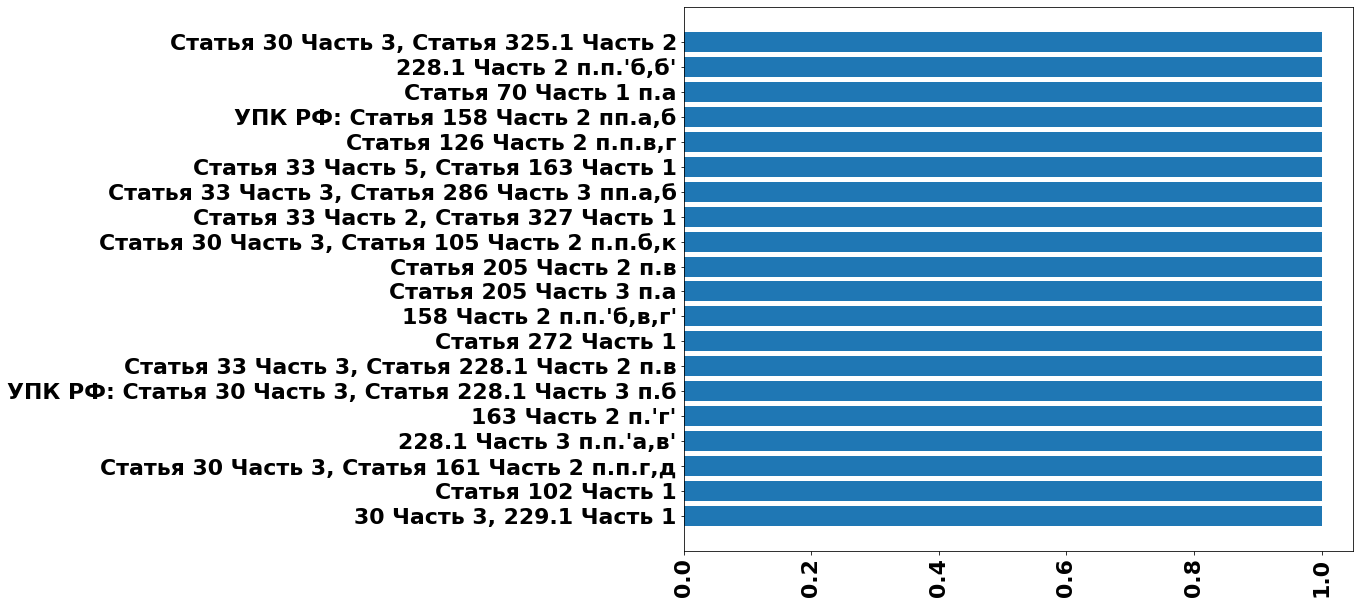

In [28]:
from collections import Counter
import matplotlib.pyplot as plt

w = Counter(flat_list).most_common()[:-20-1:-1] 
# plt.bar(w.keys(), w.values())
plt.barh([v[0] for v in w], [v[1] for v in w])
plt.xticks(rotation = 90);

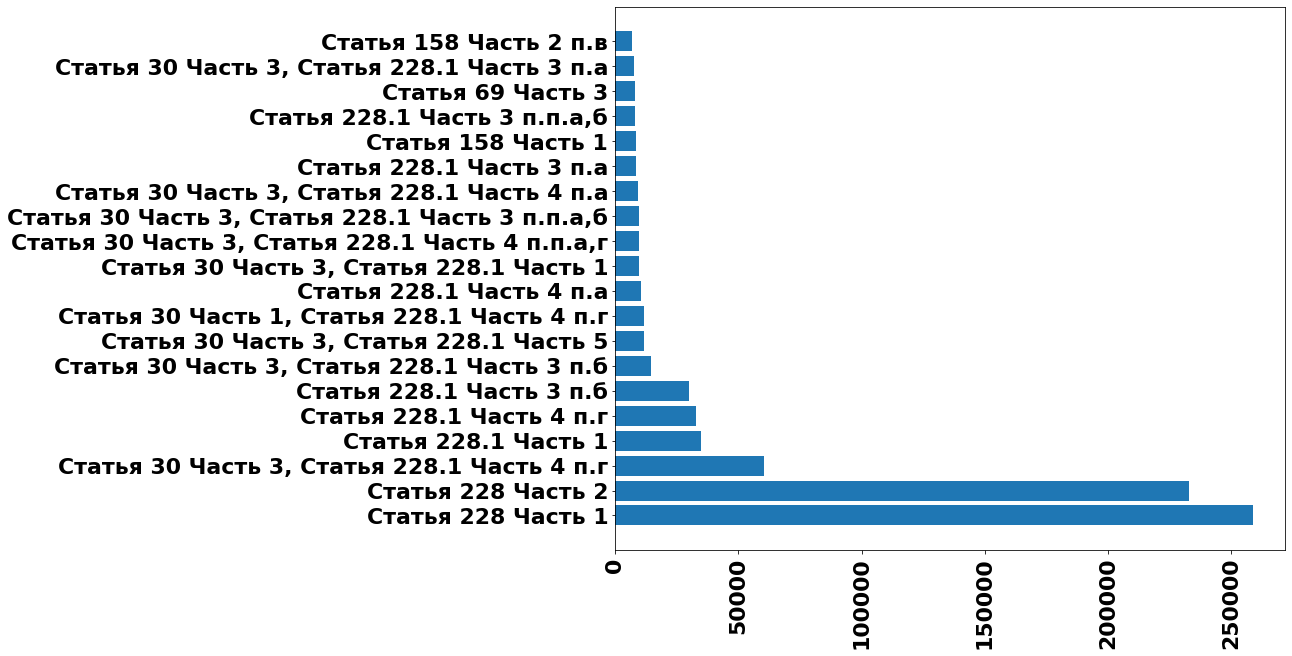

In [31]:
from collections import Counter
import matplotlib.pyplot as plt

w = Counter(flat_list).most_common(20)
# plt.bar(w.keys(), w.values())
plt.barh([v[0] for v in w], [v[1] for v in w])
plt.xticks(rotation = 90);

# Clustering

In [32]:
counts = [flat_list.count(c) for c in vocab]

In [33]:
import math
math.sqrt(5621641)

2371.0

In [34]:
from tqdm.notebook import tqdm
import numpy as np
from sklearn.cluster import AffinityPropagation
import distance
import editdistance 

words = np.asarray(vocab) #So that indexing with a list will work
print("counting similarities...")
lev_distances = []
edit_distances = []
with tqdm(total=len(words)) as pbar:
    for i, w1 in enumerate(words):
        for w2 in words:
            d = editdistance.eval(w1, w2)
            d2 =  distance.levenshtein(w1,w2)
            edit_distances.append(d)
            lev_distances.append(d2)
        pbar.update(1)
        
# distances = [[distance.levenshtein(w1,w2) for w1 in words] for w2 in words]
edit_similarity = -1*np.array(edit_distances)
lev_similarity = -1*np.array(lev_distances)

counting similarities...


  0%|          | 0/2371 [00:00<?, ?it/s]

NameError: name 'lev_similarity' is not defined

In [36]:
affprop = AffinityPropagation(affinity="precomputed", damping=0.5)
print("fitting...")
shape = math.sqrt(5621641)
affprop.fit(edit_similarity.reshape(int(shape), int(shape)))

fitting...


AffinityPropagation(affinity='precomputed')

In [37]:
import numpy as np
print(f"{len(np.unique(affprop.labels_))} Clusters...")

for cluster_id in np.unique(affprop.labels_):
    exemplar = words[affprop.cluster_centers_indices_[cluster_id]]
    cluster = np.unique(words[np.nonzero(affprop.labels_==cluster_id)])
    cluster_str = ", ".join(cluster)
    print(" - *%s:* %s" % (exemplar, cluster_str))

94 Clusters...
 - *Статья 286 Часть 3 п.п.а,в:* Статья 126 Часть 3 п.п.а,в, Статья 126 Часть 3 пп.а,в, Статья 146 Часть 3 п.п.б,в, Статья 204 Часть 7 п.п.а,в, Статья 226 Часть 3 п.п.а,г, Статья 226 Часть 4 п.п.а,б, Статья 228 Часть 3 п.п.а,в, Статья 228 Часть 3 п.п.б,в, Статья 229 Часть 3 п.п.а,б, Статья 229 Часть 3 п.п.а,б,в,г, Статья 230 Часть 2 п.п.а,в, Статья 230 Часть 3 п.п.а,б, Статья 256 Часть 1 п.п.а,в, Статья 256 Часть 1 п.п.б,в, Статья 256 Часть 1 пп.б,в, Статья 264 Часть 6 п.п.а,б, Статья 286 Часть 3 п.п.а,б, Статья 286 Часть 3 п.п.а,б,в, Статья 286 Часть 3 п.п.а,в, Статья 286 Часть 3 п.п.б,в, Статья 286 Часть 3 пп.а,б, Статья 286 Часть 3 пп.а,б,в, Статья 286 Часть 3 пп.а,в, Статья 286 Часть 3 пп.б,в, Статья 290 Часть 5 п.п.а,в
 - *Статья 30 Часть 3, Статья 158 Часть 2 пп.б,в:* Статья 30 Часть 1, Статья 158 Часть 3 пп.а,в, Статья 30 Часть 3, Статья 105 Часть 2 пп.б,е, Статья 30 Часть 3, Статья 158 Часть 2 п.п.а,б,в, Статья 30 Часть 3, Статья 158 Часть 2 п.п.а,в, Статья 30 Ча

In [ ]:
import pandas as pd
import logging
logger = logging.getLogger()


df = pd.DataFrame(records)
df.head(2)